In [1]:
import matplotlib.pyplot as plt
from utils import shapes


Lets look at some shapes

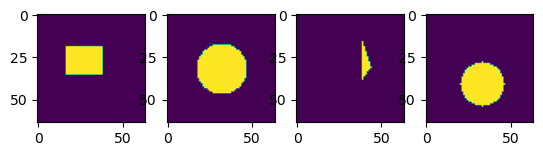

In [2]:
img_size = 64
S = shapes(img_size=img_size, noise_lvl=0.05)
fig, ax = plt.subplots(1,4)
shape_names = ['rectangle', 'circle', 'triangle', 'ellipse']
for i in range(4):
    ax[i].imshow(S.get_shape(shape_names[i]))

Let's get the model

In [3]:
from models import UNet
model = UNet()
best_model = UNet()
best_loss = float('inf')

In [4]:
import numpy as np
import torch
import torch.nn as nn
from operators import Radon

num_thetas = 10
max_angle = 90
theta = np.linspace(0,max_angle, endpoint = False, num=num_thetas)
R = Radon(theta=theta)

loss_fct = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
batch_size = 5
epochs = 400


noise_lvl = 0.02
def noise(x):
    return np.random.normal(0, noise_lvl, size=x.shape)

Let's train the net

In [5]:
train_shape = 'circle'

for epoch in range(epochs):
    optimizer.zero_grad()
   
    inp = np.zeros((batch_size, 1, img_size, img_size))
    I = np.zeros((batch_size, 1, img_size, img_size))

    # set real images and inputs
    for i in range(batch_size):
        I[i,0,...] = S.get_shape(train_shape)
        sinogram =  R(I[i,0,...])
        sinogram += noise(sinogram)
        inp[i, 0, ...] = R.inverse(sinogram)
    Irecon = model(inp)
    loss = loss_fct(Irecon, torch.Tensor(I))
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    loss1 = loss.item()
    loss2 = loss_fct(torch.Tensor(inp), torch.Tensor(I)).item()

    if loss1 < best_loss:
        best_model.load_state_dict(model.state_dict())
    print(30*'-')
    print('Epoch: ' + str(epoch))
    print('Current Loss:' + str(loss1))
    print('IRadon Loss:' + str(loss2))
    for param_group in optimizer.param_groups:
        print('Current lr:' + str(param_group['lr']))

------------------------------
Epoch: 0
Current Loss:0.1664837896823883
IRadon Loss:0.1510935127735138
Current lr:0.0009755282581475768
------------------------------
Epoch: 1
Current Loss:0.14647920429706573
IRadon Loss:0.1615791618824005
Current lr:0.0009045084971874736
------------------------------
Epoch: 2
Current Loss:0.08821616321802139
IRadon Loss:0.15801656246185303
Current lr:0.0007938926261462366
------------------------------
Epoch: 3
Current Loss:0.08901791274547577
IRadon Loss:0.1540643721818924
Current lr:0.0006545084971874737
------------------------------
Epoch: 4
Current Loss:0.050975341349840164
IRadon Loss:0.15289732813835144
Current lr:0.0005
------------------------------
Epoch: 5
Current Loss:0.04580674320459366
IRadon Loss:0.15279284119606018
Current lr:0.00034549150281252633
------------------------------
Epoch: 6
Current Loss:0.042397189885377884
IRadon Loss:0.1497056782245636
Current lr:0.0002061073738537635
------------------------------
Epoch: 7
Current Los

In [15]:
## save the model
save_model = False
if save_model:
    torch.save(model.state_dict(), train_shape + '.pt')

In [7]:
load_model = False
if load_model:
    model.load_state_dict(torch.load('circle.pt'))

Let's look at the results

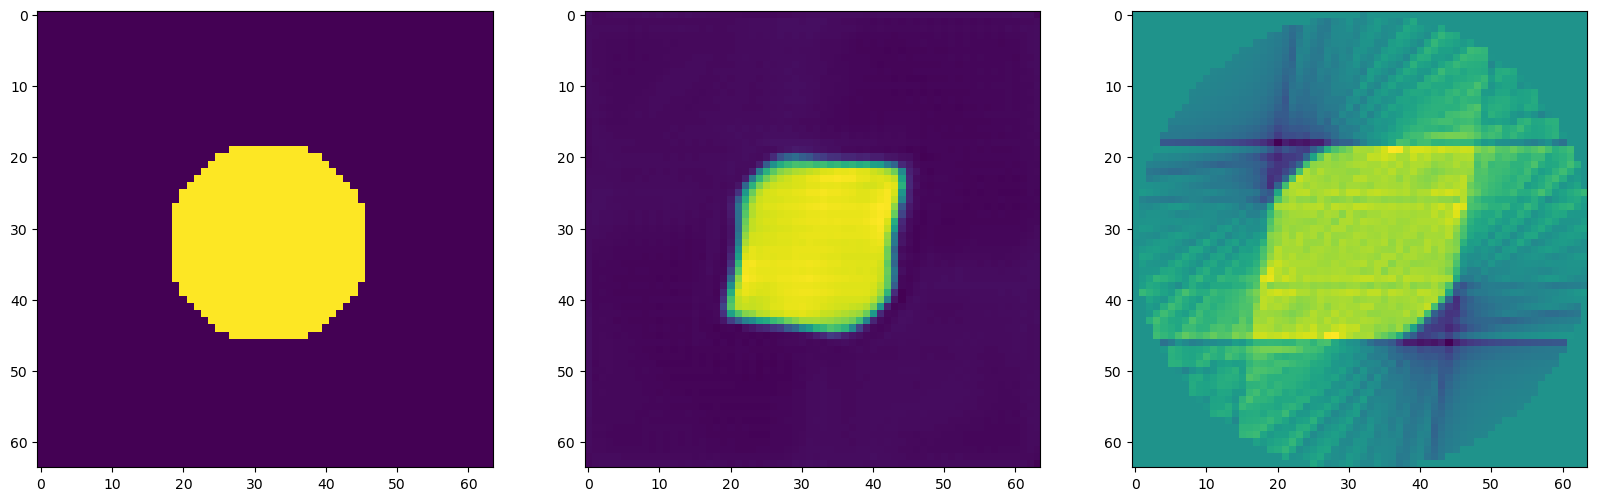

In [63]:
# %% Test
from utils import get_phantom
img_size_test=64
S_test = shapes(img_size=img_size_test)

min_angle = 90
max_angle = 180
theta = np.linspace(min_angle,max_angle, endpoint = False, num=num_thetas)
R = Radon(theta=theta)

test_shape = 'rectangle'
test_shape = 'circle'
#test_shape = 'triangle'
#test_shape = 'ellipse'
I = S_test.get_shape(test_shape)
#I = get_phantom(img_size_test)

I_sino = R(I)
#I_sino += noise(I_sino)
recon = R.inv(I_sino)
model_recon = model(recon)


fig, ax = plt.subplots(1,3, figsize = (20,15))
ax[0].imshow(I)
ax[1].imshow(model_recon.detach()[0,0,...])
ax[2].imshow(recon)

In [65]:
from optimizers import optimizer
from operators import soft_shrinkage

class proxGD(optimizer):
    def __init__(self, A, x, y, t=0.1, lamda=1.0, prox=None, **kwargs):
        super().__init__(**kwargs)
        self.A = A
        self.u = u
        self.b = b
        self.lamda = lamda
        self.t = t
        self.prox = prox if not prox is None else soft_shrinkage
    
    def step(self,):
        grad = self.A.adjoint(self.A(self.u) - self.b)
        lin_up = self.u - 2 * self.t * grad
        self.u = self.prox(lin_up, self.lamda * self.t)

In [ ]:
opt = proxGD(R, 